In [1]:
import tensorflow as tf
!pip install -U segmentation_models
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
import random
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop
from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.preprocessing.image import ImageDataGenerator
import albumentations
from segmentation_models.utils import set_trainable
import math



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.8 MB/s 
Segmentation Models: using `keras` framework.


### **Importing Dataset:**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

files_path = "/content/drive/MyDrive/A3_Dataset/dataset1/"

Mounted at /content/drive/


### **Extracting Test and Train Images & Masks from Dataset:**

**Function Declaration**

In [3]:

def openImage(imagePath, colour):       # Function to read images
  image_size = (224,224)
  normalize = 1 if colour == 0 else 255

  img = cv2.imread(imagePath, colour)
  img = cv2.resize(img, image_size) / normalize
  return img

def listFile_Directory(FOLDER_NAME):    # Function to fetch directories:
  imageList = []
  for img_path in glob.glob(os.path.join(files_path + FOLDER_NAME, "*.png")):
    imageList.append(img_path)
  
  imageList.sort()
  colour = 0 if FOLDER_NAME == TRAIN_MASKS_FOLDER or FOLDER_NAME == TEST_MASKS_FOLDER else 1
  imageList = np.stack([openImage(i, colour) for i in imageList])

  return imageList


**Loading data using above functions**

In [4]:
# Capture training image info as a list

TRAIN_IMAGES_FOLDER = "images_prepped_train/"
TRAIN_MASKS_FOLDER = "annotations_prepped_train/"
TEST_IMAGES_FOLDER = "images_prepped_test/"
TEST_MASKS_FOLDER = "annotations_prepped_test/"

train_images = listFile_Directory(TRAIN_IMAGES_FOLDER)
test_images = listFile_Directory(TEST_IMAGES_FOLDER)

train_masks = listFile_Directory(TRAIN_MASKS_FOLDER)
train_masks = np.expand_dims(train_masks, axis = -1)

test_masks = listFile_Directory(TEST_MASKS_FOLDER)
test_masks = np.expand_dims(test_masks, axis = -1)

trainData = tuple(zip(train_images, train_masks))
testData = tuple(zip(test_images, test_masks))

print("Total Train Images: ", train_images.shape, "       Total Train Masks: ", train_masks.shape)
print("Total Test Images: ", test_images.shape, "        Total Test Masks: ", test_masks.shape)


Total Train Images:  (367, 224, 224, 3)        Total Train Masks:  (367, 224, 224, 1)
Total Test Images:  (101, 224, 224, 3)         Total Test Masks:  (101, 224, 224, 1)


**Viewing a randomly chosen Image and its Mask:**

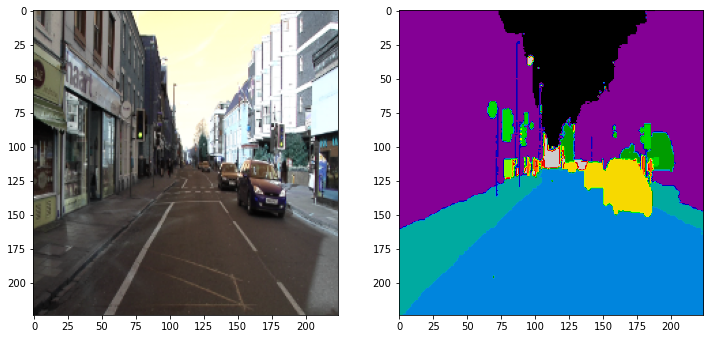

In [5]:
image_number = random.randint(0, len(train_images) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_images[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(train_masks[image_number]), cmap='nipy_spectral')
plt.show()


## **Data Augmentation**

In [6]:
import albumentations as A

# Declaring Transformation function
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=35)])

# Randomly selecting 25% of Training images and their masks for augmentation
forAugmentation = tuple(random.sample(trainData, math.ceil(0.25 * len(trainData))))

extra_augmentedList = []
for item in forAugmentation:

  image = item[0].astype(np.float32)
  mask = item[1].astype(np.float32)
  transformed = transform(image = image, mask = mask)
  transformedImage = transformed['image']
  transformedMask = transformed['mask']

  extra_augmentedList.append((transformedImage, transformedMask))

extra_augmentedList = tuple(extra_augmentedList)

**Viewing a randomly chosen Augmented Image and its Mask:**

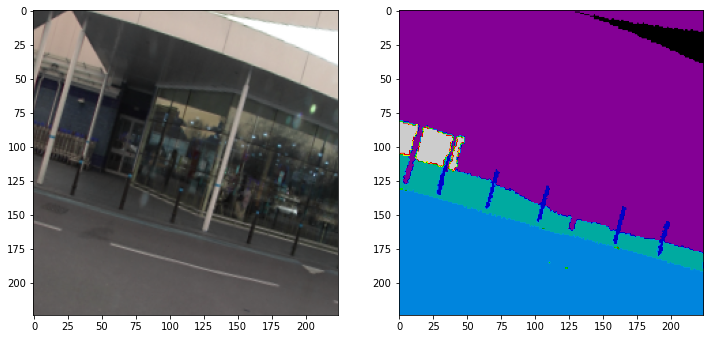

In [7]:

image_number = random.randint(0, len(extra_augmentedList) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(extra_augmentedList[image_number][0], cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(extra_augmentedList[image_number][1]), cmap='nipy_spectral')
plt.show()


**Incorporating the augmented data to existing dataset**

In [8]:
total_Train_Data = trainData + extra_augmentedList
total_Train_Data = list(total_Train_Data)
random.shuffle(total_Train_Data)

print("Total training data after augmentation: ", len(total_Train_Data))

Total training data after augmentation:  459


### **Making Input Data Categorical for Multiclass Segmentation:**

In [9]:
X_train = list(zip(*total_Train_Data))[0]
y_train = list(zip(*total_Train_Data))[1]

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)

X_test = np.array(test_images)
y_test = tf.keras.utils.to_categorical(test_masks, num_classes=12)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(459, 224, 224, 3) (459, 224, 224, 12)
(101, 224, 224, 3) (101, 224, 224, 12)


### **Implementing U-Net with various Backbones (VGG, ResNet, MobileNet):**

**Setting up Custom Losses & Evaluation Metrics:**


In [10]:
n_classes=12
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
  return 1 - numerator / denominator

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

metrics = ['accuracy', dice_coef, sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), tf.keras.metrics.SpecificityAtSensitivity(0.5)]


**Defining Function for UNet Model:**

In [11]:

def Unet_Model(BACKBONE, metrics):
  n_classes=12
  activation='softmax'
  batch_size = 16
  epochs = 35
  opt1 = SGD(learning_rate=0.001, momentum=0.9)
  # opt2 = RMSprop(learning_rate=0.001, decay=1e-6)

  # define model
  model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

  model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=metrics)

  print(model.summary())


  custom_early_stopping = EarlyStopping(monitor=['val_accuracy', 'val_iou_score'], patience=2, 
    min_delta=0.001, mode='max')
  
  callbacks = [ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
              keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/A3_Dataset/dataset1/Saved_Models/" + BACKBONE + "_semantic_segmentation.h5", save_best_only=True)]
              
  results = model.fit(X_train, y_train, batch_size=batch_size, epochs=30,
                callbacks = callbacks, verbose=1, 
                validation_data=(X_test, y_test))

  model.save(BACKBONE+"_backbone.hdf5")

  return results


**Defining function for Learning Curves:**

In [12]:
def train_val_curves(model):

  #plot the training and validation accuracy and loss at each epoch
  loss = model.history['loss']
  val_loss = model.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = model.history['iou_score']
  val_acc = model.history['val_iou_score']

  plt.plot(epochs, acc, 'y', label='Training IOU')
  plt.plot(epochs, val_acc, 'r', label='Validation IOU')
  plt.title('Training and validation IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()
  plt.show()

### **Testing Random Test Images on Models and Displaying Results:**

**Defining Functions to display results:**

In [28]:

def imageSuperimpose(original_Image, mask):
  background = original_Image
  overlay = mask
  added_image = cv2.addWeighted(background.astype(np.float32),0.35, overlay.astype(np.float32), 0.65, 0)
  plt.imshow(added_image, cmap='nipy_spectral')

def display_results(model):
  test_img_number = random.randint(0, len(X_test) - 1)

  test_img = X_test[test_img_number]
  ground_truth = test_masks[test_img_number]
  test_img_input = np.expand_dims(test_img, 0)
  test_pred = model.predict(test_img_input)
  test_prediction = np.argmax(test_pred, axis=3).reshape(224, 224, -1)

  # print(model.history.history['val_accuracy'])
  # print(model.history.history['val_iou_score'])
  # print(model.history.history['dice_coef'])
  # print(model.history.history['val_f1-score'])
  # print(model.history.history['val_specificity_at_sensitivity'])

  plt.figure(figsize = (15, 11))

  plt.subplot(231)
  plt.title('Original Test Image')
  plt.imshow(test_img, cmap='gray')

  plt.subplot(232)
  plt.title('Test Label (Ground Truth)')
  plt.imshow(np.squeeze(ground_truth), cmap='nipy_spectral')

  plt.subplot(233)
  plt.title('Predicted Test Mask')
  plt.imshow(test_prediction[:,:,0], cmap='nipy_spectral')

  plt.subplot(234)
  plt.title('Ground Truth Superimposed over Original Test Image')
  Convertgreyto3 = cv2.merge([ground_truth, ground_truth, ground_truth])
  imageSuperimpose(test_img[:,:,0], Convertgreyto3[:,:,0])

  plt.subplot(236)
  plt.title('Predicted Mask Superimposed over Original Test Image')
  Convertgreyto3 = cv2.merge([test_prediction, test_prediction, test_prediction])
  imageSuperimpose(test_img[:,:,0], Convertgreyto3[:,:,0])
  plt.show()

# **Displaying Results for Semantic Segmentation Architectures**



## **U-Net with VGG-16 Backbone**

In [14]:
BACKBONE = "vgg16"
model = Unet_Model(BACKBONE, metrics)


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                             

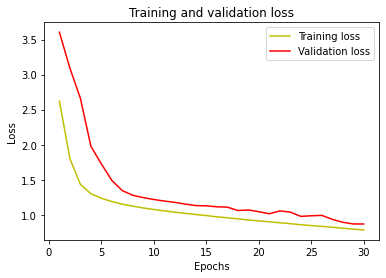

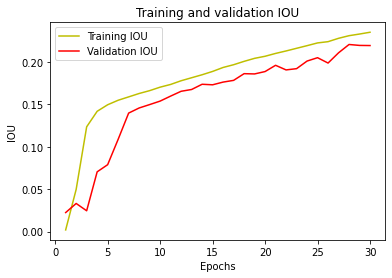

In [15]:
train_val_curves(model)

1/1 [==============================] - 0s 279ms/step


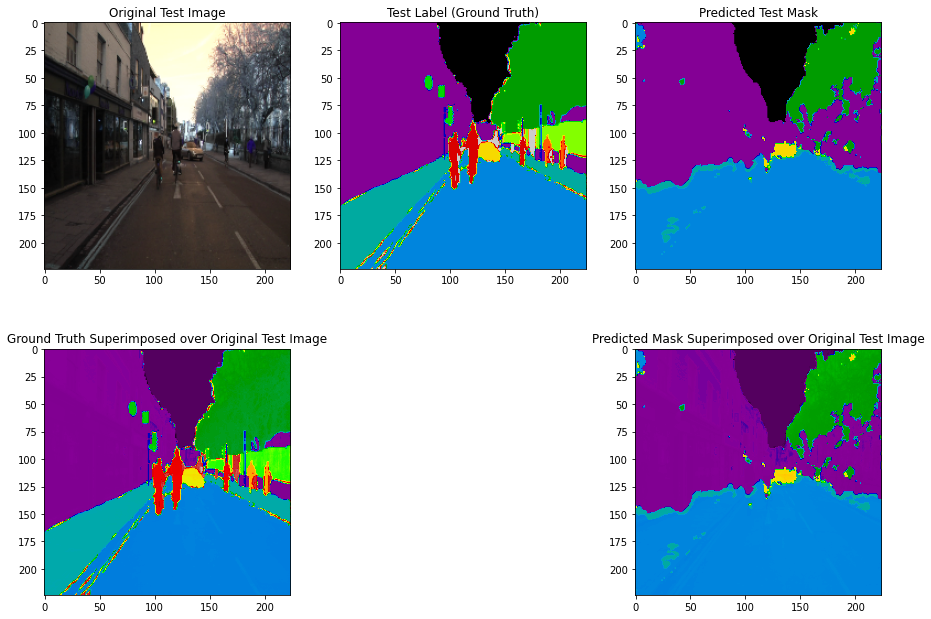

In [29]:
model = keras.models.load_model('/content/vgg16_backbone.hdf5', compile=False)
display_results(model)

## **U-Net with ResNet-34 Backbone**

In [17]:
BACKBONE = "resnet34"
model = Unet_Model(BACKBONE, metrics)


85521592/85521592 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

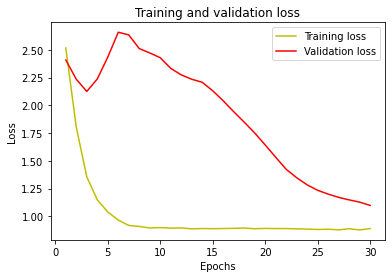

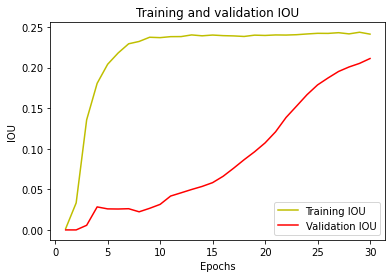

In [18]:
train_val_curves(model)


1/1 [==============================] - 1s 1s/step


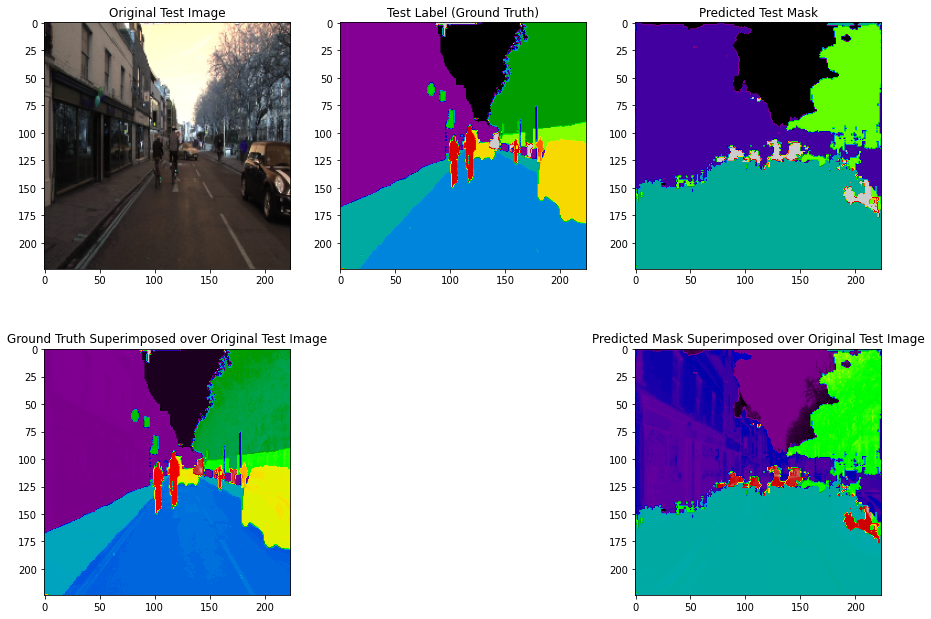

In [30]:
model = keras.models.load_model('/content/resnet34_backbone.hdf5', compile=False)
display_results(model)

# **U-Net with InceptionNet-v3 Backbone**

In [20]:
BACKBONE = "inceptionv3"
model = Unet_Model(BACKBONE, metrics)


87910968/87910968 [==============================] - 2s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                

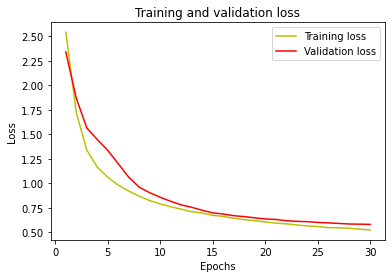

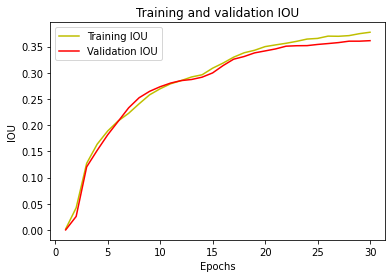

In [21]:
train_val_curves(model)

1/1 [==============================] - 1s 1s/step


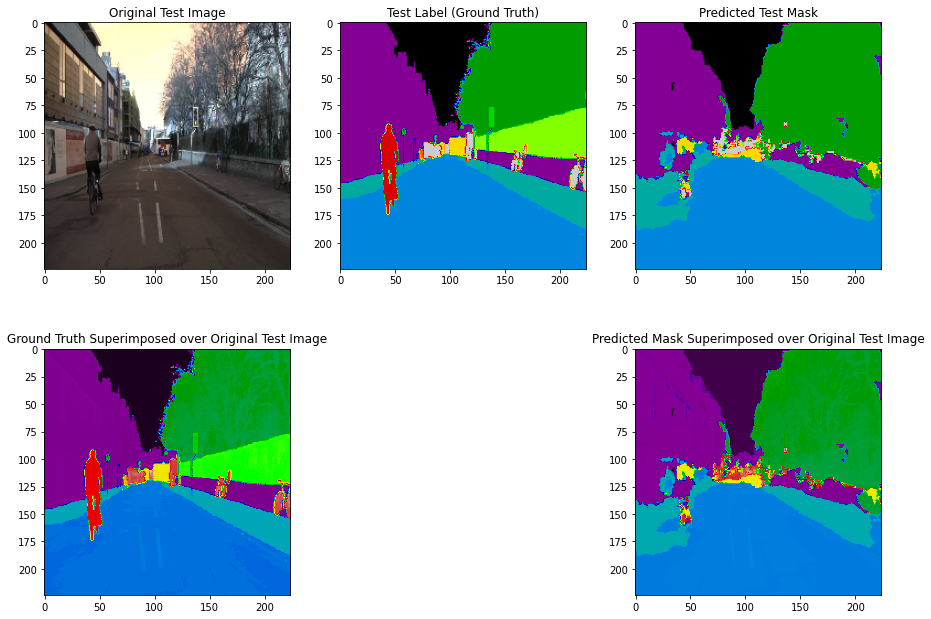

In [31]:
model = keras.models.load_model('/content/inceptionv3_backbone.hdf5', compile=False)
display_results(model)